# Building an image classifier using Sequential API

### Objectives:
    - Build an image classifier using the MNIST dataset
    - Export the resulting model to CoreML 

In [2]:
#Start by importing all tools 
import tensorflow as tf
from tensorflow import keras
import numpy as np

import pandas as pd 
import matplotlib.pyplot as plt 

import coremltools as ct

## Import the data

In [3]:
#The data set is already obtained from Keras
fashion_mnist = keras.datasets.fashion_mnist

## Exploring the dataset
***
* Check the shape and type of the data
* plot some of the images in the dataset
* you think this data is already pre-processed and ready to use?
***

In [4]:
#Lets take a look to the shape of the dataset
#What type is?
type(fashion_mnist) #type: module
#We still need to extract data.
#Notice that the data is already split in training and test data
(X_train_full, y_train_full) , (X_test, y_test) = fashion_mnist.load_data()

In [5]:
#Let's see what we got to work with
print(f'shape of training data: {X_train_full.shape}')
print(f'dtype of training data: {X_train_full.dtype}')
print(f'shape of test data: {X_test.shape}')
print(f'dtype of test data: {X_test.dtype}')
print(f'shape of labeled data: {y_train_full.shape}')
print(f'dtype of labeled data: {y_train_full.dtype}')
print(f'Max value in data: {(X_train_full.max())}')

shape of training data: (60000, 28, 28)
dtype of training data: uint8
shape of test data: (10000, 28, 28)
dtype of test data: uint8
shape of labeled data: (60000,)
dtype of labeled data: uint8
Max value in data: 255


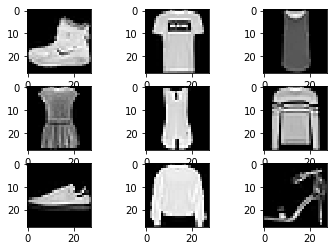

In [6]:
for i in range(9):
    #define subplot
    plt.subplot(330 + 1 + i)
    #plot the raw data 
    plt.imshow(X_train_full[i], cmap= plt.get_cmap('gray'))



**TO continue We need also a validation set, that we can extract from the trainingset** <br>
**We also need to define the output labels. This is just a string array containing the names of the classes in the dataset**

In [7]:
#Get validation data from training data

#Create Validation set
#You should have sets for: Training, validation and test
#First 5000 samples for validation, the rest for training
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
#Notice that the values in the datasets are from 0-255.
#We want to perform a Gradient Descent, so we have to scale.
#For simplicity lest scale it to its maximun
X_test = X_test / 255.0

#Prepare the class names
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [8]:
#You can check the labels in the training data:
class_names[y_train[0]]

'Coat'

### Here is an example of how the data sets looks like
<img src="fashion_mnist_sample.png">

***
# Now lets build the neural network.
***
**We will be using a MLP with 2 hidden layers**

In [9]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


*  First lines create a sequenctial model. This is the simplest kind of keras model for a neural network. 
<a href= "https://keras.io/guides/sequential_model/"> More Info.</a>

* The Flatten layer convert each input image (28,28) into a 1D array. If it reaceives X input data, it computes X.reshape(-1,1). Since it is the first layer in the model, you should specify the input_shape, which doesn't include the batch size, only the shape of the instances.
<a href="https://keras.io/api/layers/reshaping_layers/flatten/"> More Info</a>

* Now lets add a Dense (fully conected) layer. You need to specify the number of neurons in the layer and the activation function. Each Dense layer manages its own weight matrix, containing all the connection weights between the neurons and their inputs. It also manage a vector of bias terms (one per neuron). When receives input data it executes:  $h_{W,b} = ø(XW + b)$
 * Then we add a second Dense hidden layer with 100 neurons, also using the ReLU activation function.
 
 *  Finally we add another Dense OUTPUT layer, with 10 neurons (one per class). We use softmax activation function because the classes are exclusive
 
 <a href="https://keras.io/api/layers/activations/">Check for more activation functions</a>



In [10]:
# You can get a reference to the model's layer list by:
model.layers
hidden1 = model.layers[1]
print(f'layer hidden1 = {hidden1.name}')
model.get_layer('dense_9') is hidden1

layer hidden1 = dense


ValueError: No such layer: dense_9

All parameters of a layer can be accessed using its get_weights() and set_weights() methods. For example, for this specific neural network the first hidden layer would have 235500 parameters, this will be accommodated in the matrix W and the vector of Biases<br>

where rows match the input number: $m =784$, and there is one column per neuron in the layer $n = 300$ <br>
$ W = \begin{bmatrix} 
    w_{0,0} & w_{0,1}&w_{0,2}&...&w_{0,n}\\
    w_{1,0}& w_{1,1}&w_{1,2}&...&w_{1,n}\\
    & &...& \\
    w_{m,0}&w_{m,1}&w_{m,2}&...&w_{m,n}
       \end{bmatrix}$
<br>
<br>
There will be 1 bias per neuron in the layer, $n = 300$
<br>
$B = \begin{bmatrix}
b_{0} & b_{1} & ... & b_{n}
\end{bmatrix}
$
<br>
<br>


In [ ]:
weights, biases = hidden1.get_weights()
print(f'weights matrix: {weights.shape}')
print(f'biases vector: {biases.shape}')



*Notice that the Dense layer initialized the connection weights randomly (which is needed to break symmetry, as we discussed earlier), and the biases were initialized to zeros, which is fine. If you ever want to use a different initialization method, you can set kernel_initializer (kernel is another name for the matrix of connection weights) or bias_initializer when creating the layer*
## Now is time to compile the model

In [11]:
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])


* We use the *sparse_categorical_crossentropy*  because we have sparse labels and the classes are exclusive 
* If instead we had one target probability per class for each instance ((such as one-hot vectors, e.g. [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.] to represent class 3) the we would need to use *categorical_crossentropy*
* If we were doing binary classification (with one or more binary labels), then we would use the *sigmoid* (i.e., logistic) activation function in the output layer instead of the *softmax* activation function, and we would use the *binary_crossentropy* loss.
* the **SDG**  means that we will using the simple Stochastic Gradient Descent. When using the SGD optimizer, it is important to tune the learning rate. So, you will generally want to use optimizer=keras.optimizers.SGD(lr=???) to set the learning rate, rather than optimizer="sgd", which defaults to lr=0.01.
* Finally, since this is a classifier, it's useful to measure its **accuracy** during the traning evaluation

In [12]:
# After the model is created you must call its compile() method
# to specify the loss function and optimizer to use.
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"]) #you can specify a list of metrics to compute during training

In [13]:
# now the model is ready to be trained
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 4s 65us/sample - loss: 0.7041 - accuracy: 0.7699 - val_loss: 0.5239 - val_accuracy: 0.8200
Epoch 2/30
55000/55000 [==============================] - 3s 60us/sample - loss: 0.4837 - accuracy: 0.8322 - val_loss: 0.4270 - val_accuracy: 0.8566
Epoch 3/30
55000/55000 [==============================] - 3s 61us/sample - loss: 0.4397 - accuracy: 0.8469 - val_loss: 0.4204 - val_accuracy: 0.8544
Epoch 4/30
55000/55000 [==============================] - 3s 60us/sample - loss: 0.4129 - accuracy: 0.8554 - val_loss: 0.3844 - val_accuracy: 0.8718
Epoch 5/30
55000/55000 [==============================] - 3s 61us/sample - loss: 0.3936 - accuracy: 0.8615 - val_loss: 0.3775 - val_accuracy: 0.8676
Epoch 6/30
55000/55000 [==============================] - 3s 61us/sample - loss: 0.3772 - accuracy: 0.8674 - val_loss: 0.3660 - val_accuracy: 0.8744
Epoch 7/30
55000/55000 [==============================] -

**Notice how keras displays training information at each epoch**
* the number of instances processed so far along with a progress bar 
* mean training time per sample
* loss
* accuracy(or any other extra metrics you asked for )

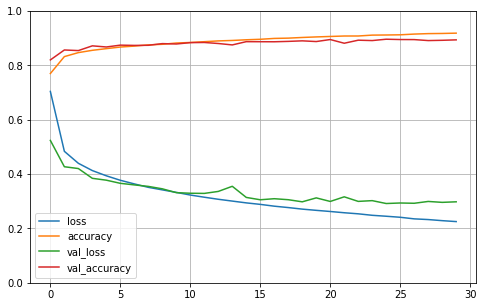

In [14]:
import pandas as pd 
import matplotlib.pyplot as plt 

history_dataframe = pd.DataFrame(history.history)
history_dataframe.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()


In [46]:
model.evaluate(X_test,y_test)

10000/10000 [==============================] - 0s 35us/sample - loss: 0.3264 - accuracy: 0.8836


[0.3263827322602272, 0.8836]

## Using the model to make predictions

In [15]:
#Using predict, allows you see the output layer completely
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.97],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [16]:
#If you are only interested in the class with the highest estimated probability
#you could use predict_classes, you get the index of the 
#output layer array with the highest score.
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1])

In [17]:
#you can use these indexes to get the class names
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [18]:
#Which is the correct answer
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

# Saving and restoring the Model

In [19]:
model.save("keras_model_classifier_fashion_mnist.h5")

In [21]:
keras_model = keras.models.load_model("keras_model_classifier_fashion_mnist.h5")

In [35]:
import coremltools as ct
# Define the input type as image, 
# set pre-processing parameters to normalize the image 
# to have its values in the interval [-1,1] 
# as expected by the mobilenet model
image_input = ct.ImageType(name="input_image",
                            shape=(28, 28, 1),
                            scale=1/255,
                          color_layout = 'G')

print(type(image_input))
# set class labels
classifier_config = ct.ClassifierConfig(class_names)

# Convert the model using the Unified Conversion API
model = ct.convert(
     keras_model, inputs=[image_input], classifier_config=classifier_config,
)

<class 'coremltools.converters.mil.input_types.ImageType'>


Translating MIL ==> MLModel Ops: 100%|██████████| 15/15 [00:00<00:00, 387.25 ops/s]


In [37]:
# Set feature descriptions (these show up as comments in XCode)
#model.input_description["input_image"] = "A gray scale image of 28x28 (28,28,1)"
model.output_description["classLabel"] = "An class label from the Fashion MNIST dataset"

# Set model author name
model.author = '"From HandsOnMachineLearning book'

# Set the license of the model
model.license = ""

# Set a short description for the Xcode UI
model.short_description = "Basic implementation of a Teras Image Classifier using the Fashion MNIST"

# Set a version for the model
model.version = "1.0"

In [38]:
model.save("keras_basic_image_classifer.mlmodel")

In [39]:
model.input_description

Features(flatten_input)

In [40]:
model.input_description["flatten_input"]

''

In [66]:
example_image = X_test[0:1]
out_dict = model.predict({"flatten_input": example_image})

In [67]:
print(out_dict["classLabel"])

Ankle boot


In [70]:
X_test.shape

(10000, 28, 28)